<a href="https://colab.research.google.com/github/juhiishah/Time_Series_Analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perform standard imports, load and plot the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('/content/drive/MyDrive/Deep Learning Data/Energy_Production.csv', index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


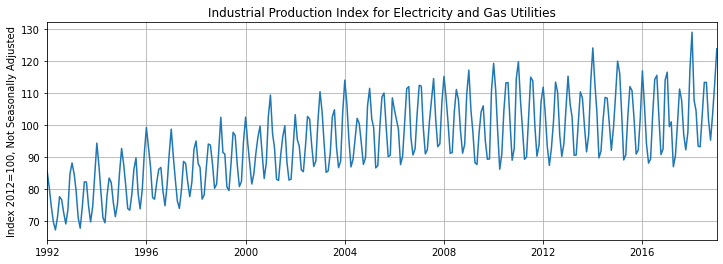

In [3]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show();

**1. Divide the data into train and test sets**

Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [4]:
y = df['IPG2211A2N'].values.astype(float)

test_size=12
window_size=12

train_set = y[:-test_size]
test_set = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test: {len(test_set)}')

Train: 313
Test: 12


**2. Normalize the training set**

Feature scale the training set to fit within the range(-1,1)

In [6]:
scaler = MinMaxScaler(feature_range=(-1,1))

train_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 85.556
First item, scaled: [-0.4091274]


**3. Prepare the data for LSTM**

Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [7]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
  out = []
  L = len(seq)
  for i in range(L-ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    out.append((window,label))
  return out

In [8]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 301


**4. Define the model**

In [22]:
class LSTMnetwork(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, output_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    
    #Add LSTM layer:
    self.lstm = nn.LSTM(input_size,hidden_size)

    # Add a fully-connected layer:
    self.linear = nn.Linear(hidden_size,output_size)

    # Initialize h0 and c0:
    self.hidden = (torch.zeros(1,1,self.hidden_size),
                   torch.zeros(1,1,self.hidden_size))
    
  def forward(self,seq):
    lstm_out, self.hidden = self.lstm(
        seq.view(len(seq),1,-1), self.hidden
    )
    pred = self.linear(lstm_out.view(len(seq),-1))
    return pred[-1]

In [23]:
torch.manual_seed(42)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

**5. Define loss and optimization functions**

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

**6. Train the model**

In [27]:
epochs = 50

for i in range(epochs):
  for seq, y_train in train_data:

    #reset the parameters and hidden states
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                   torch.zeros(1,1,model.hidden_size))
    # apply the model
    y_pred = model(seq)

    # update the parameters
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()

  print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

**7. Evaluate the model using the test set**



In [29]:
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))
    preds.append(model(seq).item())

preds[window_size:]

[0.23451170325279236,
 0.01839952915906906,
 -0.32585710287094116,
 -0.20786073803901672,
 0.22282353043556213,
 0.45058125257492065,
 0.2707202732563019,
 -0.10169830173254013,
 -0.2524860203266144,
 0.024789035320281982,
 0.5496387481689453,
 0.6445781588554382]

8. Inverse transform the predicted values

Rescale the predicted values up to the original test set range

In [30]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))
true_predictions

array([[105.35723529],
       [ 98.70865231],
       [ 88.11776916],
       [ 91.74786832],
       [104.9976545 ],
       [112.00450694],
       [106.47117385],
       [ 95.0139026 ],
       [ 90.37499383],
       [ 98.90522228],
       [115.05196127],
       [117.97272477]])

Plot the result

plot the true_predictions values together with the original data.

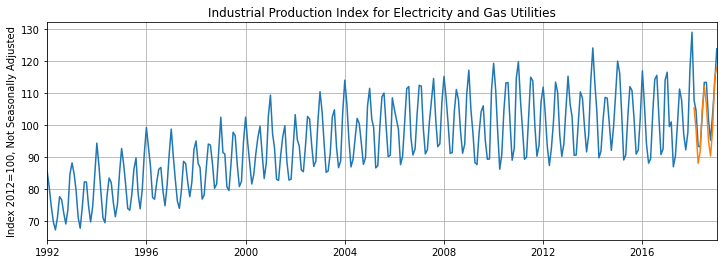

In [31]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

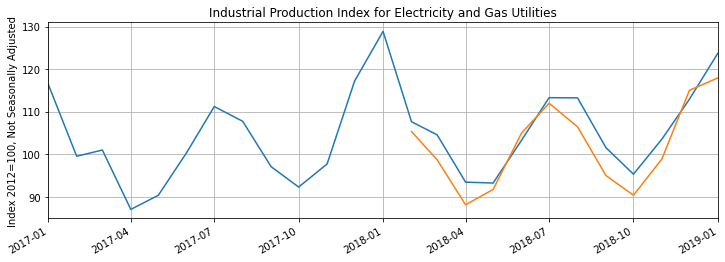

In [33]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

Forecast into an unknown future

In [34]:
epochs = 50

#set model back to training mode
model.train()

# feature scale the entire dataset

y_norm = scaler.fit_transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

for i in range(epochs):
  for seq, y_train in train_data:

    #reset the parameters and hidden states
    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                   torch.zeros(1,1,model.hidden_size))
    # apply the model
    y_pred = model(seq)

    # update the parameters
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()

  print(f'{i+1} of {epochs} epochs completed')

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

Predict future values

In [35]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

In [36]:
# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

Plot the result

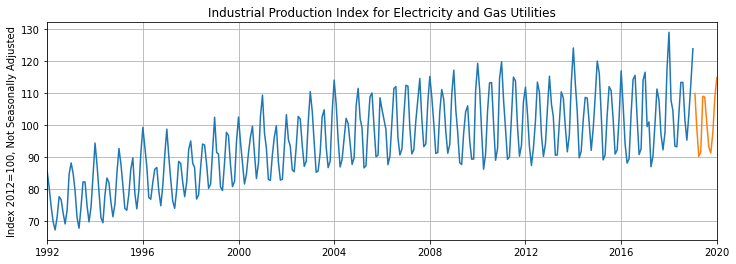

In [40]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions[window_size:])
plt.show()

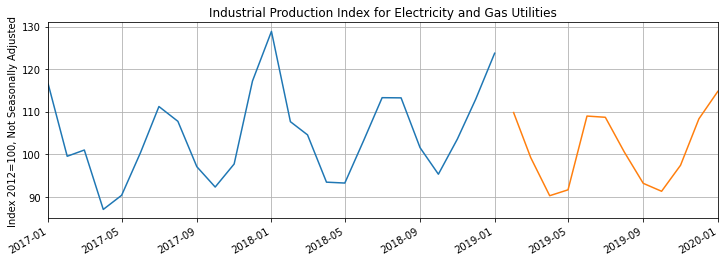

In [41]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()